In [1]:
import numpy as np
from scipy.sparse import csr_matrix, issparse
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [2]:
def print_matrix(A):
    for row in A.astype(int):
        for x in row:
            print(f"{x:>6d}", end=" ")
        print()

In [3]:
class sparse_mtx:
    def __init__(self, lst):
        self.lst = lst
        self.n = len(self.lst)

    def dot(self, x, i):
        ans = 0
        for value, idx in self.lst[i % self.n]:
            ans += value * x[idx]
        return ans

    def __call__(self, i, j):
        for value, idx in self.lst[i % self.n]:
            if idx == j:
                return value
        return None

In [4]:
def construct(n: int):
    def u(x, y):
        return np.sin(np.pi * x) * np.sin(2 * np.pi * y)

    def f(x, y):
        return (5 * np.pi ** 2 + np.exp(x * y)) * u(x, y)

    h = 1 / (n + 1)
    nn = n ** 2
    a = 4 * (n + 1) ** 2
    b = -1 * (n + 1) ** 2

    row = []
    col = []
    elem = []

    xs = np.zeros(shape=(nn, 1))
    ys = np.zeros(shape=(nn, 1))

    for i in range(n):
        for j in range(n):
            k = i + j * n
            x = (i + 1) * h
            y = (j + 1) * h

            row.append(k)
            col.append(k)
            elem.append(a + np.exp(x * y))

            if i >= 1:
                row.append(k)
                col.append(k - 1)
                elem.append(b)
            if i <= n - 2:
                row.append(k)
                col.append(k + 1)
                elem.append(b)

            if j >= 1:
                row.append(k)
                col.append(k - n)
                elem.append(b)
            if j <= n - 2:
                row.append(k)
                col.append(k + n)
                elem.append(b)
            
            xs[k] = x
            ys[k] = y
    return csr_matrix((elem, (row, col)), shape=(nn, nn)), u(xs, ys), f(xs, ys)


def sor(A, b, w: float = 1, u: np.ndarray = None, max_iter: int = 500, eps: float = 1e-8):
    x = np.zeros_like(b)
    x_ = x.copy()
    x__ = x_.copy()
    history = np.zeros(max_iter)
    A = [row for row in A]

    num_iter = -1
    for _ in range(max_iter):
        num_iter += 1
        x__ = x_.copy()
        x_ = x.copy()
        for i in range(b.shape[0]):
            # s1 = np.sum(A[i][0, :i] * x[:i])
            # s2 = np.sum(A[i][0, i + 1:] * x_[i + 1:])
            # x[i] = (1 - w) * x_[i] + w / A[i][0, i] * (b[i] - s1 - s2)

            if issparse(A[i]):
                x[i] += w * (b[i] - A[i].dot(x).ravel()) / A[i][0, i]
            else:
                x[i] += w * (b[i] - A[i].dot(x).ravel()) / A[i][i]

        if u is not None:
            history[num_iter] = np.linalg.norm(x - u, ord=np.inf)

        # q = ((x - x_).T @ (x - x_) / ((x_ - x__).T @ (x - x_))).ravel()[0]
        # if q * np.linalg.norm(x - x_, ord = np.inf) / (1 - q) <= eps:
        #     if num_iter < 3:
        #         continue
        #     else:
        #         break

    if u is not None:
        return x, history[:num_iter + 1]
    else:
        return x


In [5]:
def plot(n: int, w_lst = [1]):
    for w in w_lst:
        A, u, f = construct(n)
        x, data = sor(A.A, f, w, u=u)
        plt.plot(np.arange(data.shape[0]), np.log(data), label = f"$\omega$ = {w}")
    plt.legend()
    plt.xlabel("number of iterations")
    plt.ylabel("log(error)")
    plt.show()

In [6]:
w_lst = [1, 1.3, 1.6, 1.8, 1.9]

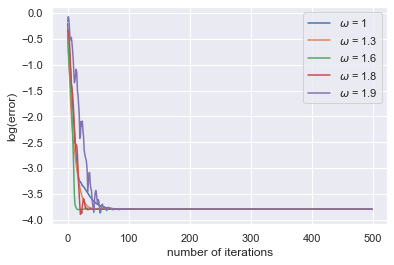

Wall time: 1.9 s


In [7]:
%%time
plot(10, w_lst)

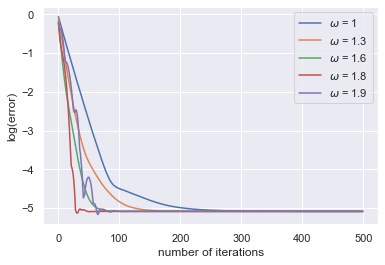

Wall time: 5.7 s


In [8]:
%%time
plot(20, w_lst)

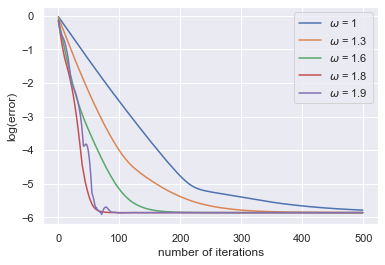

Wall time: 12.9 s


In [9]:
%%time
plot(30, w_lst)

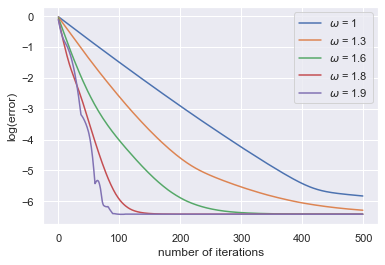

Wall time: 24.3 s


In [10]:
%%time
plot(40, w_lst)

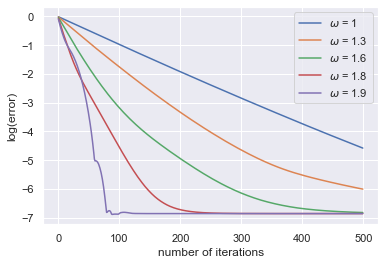

Wall time: 41 s


In [11]:
%%time
plot(50, w_lst)

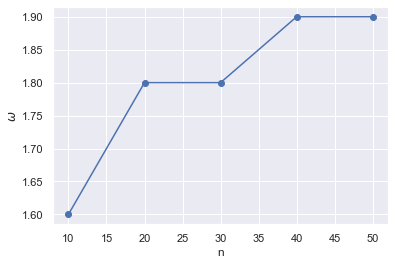

In [12]:
n = [10, 20, 30, 40, 50]
w = [1.6, 1.8, 1.8, 1.9, 1.9]
plt.plot(n, w, "o-")
plt.xlabel("n")
plt.ylabel("$\omega$")
plt.show()

С ростом `n` оптимальное $\omega$ также по-тихоньку растет: например, для `n = 10` $\omega_{\text{opt}} \simeq 1.6$, а для `n = 50` $\omega_{\text{opt}} \simeq 1.9$, так как угол наклона сильнее.